<h1 style="text-align: center;">
    Trabajo Práctico
</h1>

<h2 style="text-align: center;">
    Sistemas Automáticos de Diagnóstico y Detección de Fallas II
</h2>

<h3 style="text-align: center;">
    Alumnos
</h3>

<div style="display: flex;justify-content: center;align-items: center">
<table>
  <tbody>
    <tr>
      <th><h5 style="text-align: center;">Nombre</h5></th>
      <th><h5 style="text-align: center;">Padrón</h5></th>
    </tr>
    <tr>
      <td><h5 style="text-align: center;">Barreneche Franco</h5></td>
      <td><h5 style="text-align: center;">102205</h5></td>
    </tr>
    <tr>
      <td><h5 style="text-align: center;">Botta Guido</h5></td>
      <td><h5 style="text-align: center;">102103</h5></td>
    </tr>
    <tr>
      <td><h5 style="text-align: center;">Carol Lugones Ignacio</h5></td>
      <td><h5 style="text-align: center;">100073</h5></td>
    </tr>
    <tr>
      <td><h5 style="text-align: center;">Pernin Alejandro</h5></td>
      <td><h5 style="text-align: center;">92216</h5></td>
    </tr>
  </tbody>
</table>
</div>

# Importación de bibliotecas

In [1]:
import numpy as np
import pandas as pd
from copy import copy
import random
import os                                                 
import sys
import dowhy
from dowhy import CausalModel
module_path = os.path.abspath(os.path.join('../server'))                                                      
if module_path not in sys.path:                        
    sys.path.append(module_path)                    
from expertSystem.expertSystem import getCandidateBeers

# Generación de DataSet sintético

In [2]:
INTENSITY_TYPES = ["baja", "media", "alta"]
COLOR_TYPES = ["palido", "ambar", "oscuro"]
BITTERNESS_TYPES = ["bajo", "medio", "alto"]
HOP_TYPES = ["viejo mundo", "nuevo mundo"]
FERMENTATION_TYPES = ["baja", "media", "alta"]
YEAST_TYPES = ["lager", "ale"]

In [3]:
NUM_CLIENTS = 8000

feature_types = {
    'intensity': INTENSITY_TYPES,
    'color': COLOR_TYPES,
    'bitterness': BITTERNESS_TYPES,
    'hop': HOP_TYPES,
    'fermentation': FERMENTATION_TYPES,
    'yeast': YEAST_TYPES,
}
template = {
    'intensity': '*',
    'color': '*',
    'bitterness': '*',
    'hop': '*',
    'fermentation': '*',
    'yeast': '*'
}
features = list(template.keys())

responses = []
for client_idx in range(NUM_CLIENTS):
    response = copy(template)
    random.shuffle(features)
    for feature in features:
        response[feature] = random.choice(feature_types[feature])
        engine_result = getCandidateBeers(response)
        candidates = engine_result['candidateBeers']
        if not candidates:
            response['beer'] = 'None'
            responses.append(response)
            break
        if len(candidates) == 1:
            response['beer'] = candidates[0]
            responses.append(response)
            break

result_df = pd.DataFrame(responses)
result_df.head(10)

,intensity,color,bitterness,hop,fermentation,yeast,beer
0,*,*,alto,*,*,*,Ipa Blanca
1,media,*,*,*,alta,ale,Kolsch
2,media,ambar,medio,*,*,ale,None
3,*,oscuro,bajo,viejo mundo,*,*,Lager Ambar Checa
4,alta,*,*,*,*,ale,Ipa Blanca
5,baja,palido,*,*,*,*,Cream Ale
6,*,ambar,*,*,*,lager,Lager Ambar Checa
7,*,*,alto,nuevo mundo,*,*,Ipa Blanca
8,alta,*,*,*,*,lager,Baltic Porter
9,media,oscuro,medio,*,*,*,Lager Ambar Checa


In [4]:
result_df['color'].unique()

array(['*', 'ambar', 'oscuro', 'palido'], dtype=object)

# Análisis de inferencia causal

In [5]:
intensity_mapping = {"*":0,"baja":1,"media":2,"alta":3}
color_mapping = {'*': 0, 'palido': 1, 'oscuro': 2, 'ambar': 3}
bitterness_mapping = {"*":0,"bajo":1,"medio":2,"alto":3}
hop_mapping ={"*": 0, "viejo mundo" : 1, "nuevo mundo": 2}
fermentation_mapping = intensity_mapping
yeast_mapping = {"*":0, "lager":1, "ale":2}
beer_mapping = {'Cream Ale': 0, 'None': 1,'Kolsch': 2, 'Lager Ambar Checa': 3, 'Baltic Porter': 4, 'Ipa Blanca': 5}

result_df = result_df.replace({
    'intensity': intensity_mapping,
    'color': color_mapping,
    'bitterness': bitterness_mapping,
    'hop': hop_mapping,
    'fermentation': fermentation_mapping,
    'yeast': yeast_mapping,
    'beer': beer_mapping
})
result_df

,intensity,color,bitterness,hop,fermentation,yeast,beer
0,0,0,3,0,0,0,5
1,2,0,0,0,3,2,2
2,2,3,2,0,0,2,1
3,0,2,1,1,0,0,3
4,3,0,0,0,0,2,5
...,...,...,...,...,...,...,...
7995,1,0,2,0,2,0,0
7996,0,0,3,0,0,0,5
7997,0,1,0,1,0,0,2
7998,0,0,3,0,0,0,5


In [6]:
def generate_causal_model(target_feature):
    target_df = result_df.copy()
    target_df['treatment'] = result_df[target_feature] != 0
    causal_graph = """digraph {
                        hop;
                        fermentation;
                        yeast;
                        
                        intensity;
                        color;
                        bitterness;
    
                        treatment;
    
                        hop->beer;
                        fermentation->beer;
                        yeast->beer;
                        intensity->beer;
                        color->beer;
                        bitterness->beer;
                        treatment->beer;
                        Z->treatment;
                   """ 
    causal_graph = causal_graph + target_feature + "->treatment;}"
    model = dowhy.CausalModel(data=target_df,
                              graph=causal_graph.replace("\n", " "),
                              treatment="treatment",
                              outcome="beer")
    #model.view_model()
    return model

In [7]:
def refute_model(model):
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(identified_estimand,
                                     method_name='backdoor.propensity_score_matching',
                                     target_units='att')
    refutation = model.refute_estimate(identified_estimand, 
                                       estimate, 
                                       method_name='placebo_treatment_refuter',
                                       placebo_type='permute', 
                                       num_simulations=20)
    return refutation

## Features invididuales

In [8]:
p_values = dict()
for feature in features:
    print(feature.upper())
    model = generate_causal_model(feature)
    refutation = refute_model(model)
    p_values[feature] = refutation.refutation_result['p_value']
    print(refutation)

COLOR


/home/franco/.local/lib/python3.10/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Refute: Use a Placebo Treatment
Estimated effect:0.1348870056497175
New effect:0.1932909604519774
p value:0.4331815547945916

FERMENTATION


/home/franco/.local/lib/python3.10/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Refute: Use a Placebo Treatment
Estimated effect:1.2011303191489362
New effect:-0.06288231382978723
p value:0.4815522960065627

INTENSITY


/home/franco/.local/lib/python3.10/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Refute: Use a Placebo Treatment
Estimated effect:-1.0367222033321999
New effect:-0.052550153009180554
p value:0.4781852255149063

YEAST


/home/franco/.local/lib/python3.10/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Refute: Use a Placebo Treatment
Estimated effect:-0.9491525423728814
New effect:-0.18861710323574732
p value:0.4397209843275409

HOP


/home/franco/.local/lib/python3.10/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Refute: Use a Placebo Treatment
Estimated effect:0.06238395841069439
New effect:-0.08533234311177126
p value:0.47456642490380774

BITTERNESS


/home/franco/.local/lib/python3.10/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Refute: Use a Placebo Treatment
Estimated effect:-2.4541098415038705
New effect:-0.07659417618872093
p value:0.4729234727265542



In [9]:
feature = 'yeast'
print(feature.upper())
model = generate_causal_model(feature)
refutation = refute_model(model)
print(refutation)

YEAST


/home/franco/.local/lib/python3.10/site-packages/dowhy/causal_model.py:557: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Refute: Use a Placebo Treatment
Estimated effect:-0.9491525423728814
New effect:0.10059707241910634
p value:0.4641169839504115



In [10]:
print(p_values)

{'color': 0.4331815547945916, 'fermentation': 0.4815522960065627, 'intensity': 0.4781852255149063, 'yeast': 0.4397209843275409, 'hop': 0.47456642490380774, 'bitterness': 0.4729234727265542}


In [11]:
weights = dict()
total = 0
for feature, p_value in p_values.items():
    weight = 1 - p_value
    weights[feature] = weight
    total += weight

for feature in weights.keys():
    weights[feature] = weights[feature]/total

print(weights)

{'color': 0.1760376778752104, 'fermentation': 0.16101510224789053, 'intensity': 0.16206081851843027, 'yeast': 0.17400671716927962, 'hop': 0.1631847150000282, 'bitterness': 0.1636949691891609}


In [12]:
x = weights
l = {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
for k in l.keys():
    print(k, l[k])

fermentation 0.16101510224789053
intensity 0.16206081851843027
hop 0.1631847150000282
bitterness 0.1636949691891609
yeast 0.17400671716927962
color 0.1760376778752104


## Features jerarquizadas

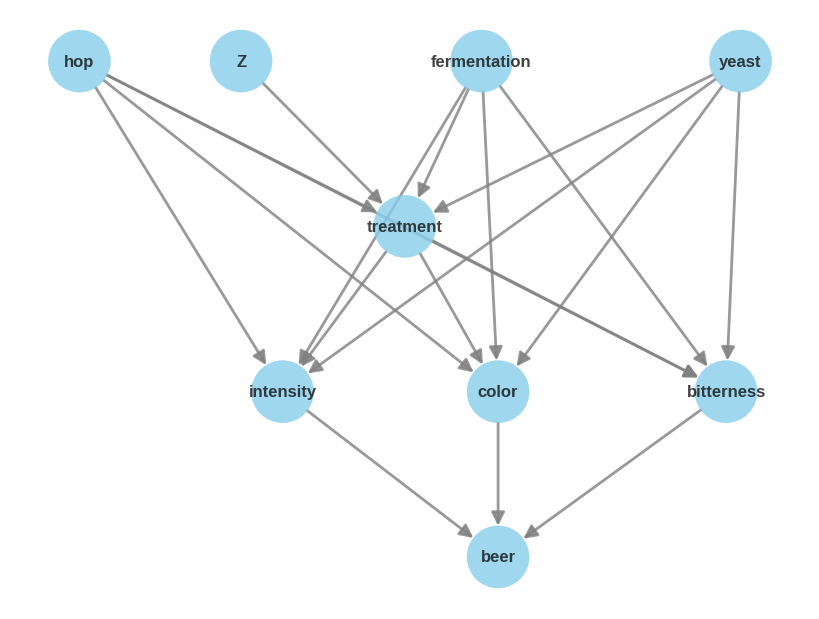

Refute: Use a Placebo Treatment
Estimated effect:-0.0641025641025641
New effect:-0.47820512820512817
p value:0.1831970590546248



In [37]:
target_df = result_df.copy()
target_df['treatment'] = (target_df['intensity'] != 0) & (target_df['fermentation'] != 0) & (target_df['color'] != 0)
causal_graph = """digraph {
                    hop;
                    fermentation;
                    yeast;
                    
                    intensity;
                    color;
                    bitterness;

                    treatment;

                    intensity->beer;
                    color->beer;
                    bitterness->beer;
                    
                    Z->treatment;
                    hop->intensity;
                    yeast->intensity;
                    fermentation->intensity;
                    
                    hop->color;
                    yeast->color;
                    fermentation->color;
                    
                    hop->bitterness;
                    yeast->bitterness;
                    fermentation->bitterness;
                    
                    hop->treatment;
                    yeast->treatment;
                    fermentation->treatment;
                    
                    treatment->bitterness;
                    treatment->color;
                    treatment->intensity;
                }
               """ 
model = dowhy.CausalModel(data=target_df,
                          graph=causal_graph.replace("\n", " "),
                          treatment="treatment",
                          outcome="beer")
model.view_model()
print(refute_model(model))

# IA Explainable

,Description,Value
0,Session id,123
1,Target,beer
2,Target type,Multiclass
3,Original data shape,"(8000, 7)"
4,Transformed data shape,"(8000, 7)"
5,Transformed train set shape,"(5600, 7)"
6,Transformed test set shape,"(2400, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


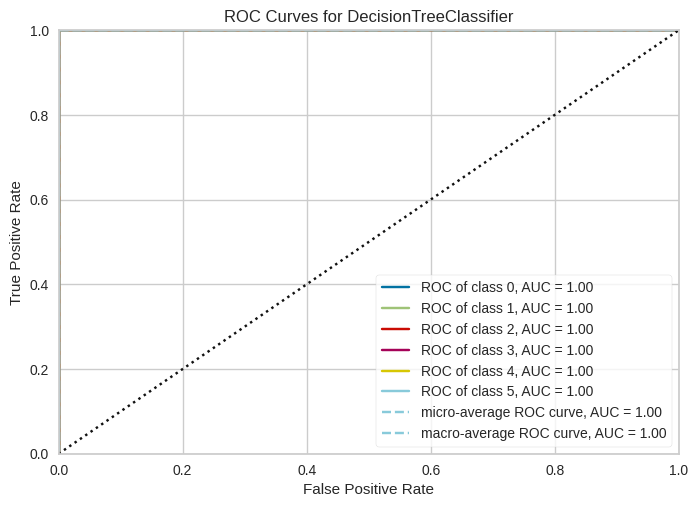

In [14]:
from pycaret.datasets import get_data
from pycaret.classification import *
data = result_df
clf1 = setup(data, target = 'beer', session_id=123)
#best_model = compare_models()
dt = create_model('dt', cross_validation=False)
plot_model(dt)

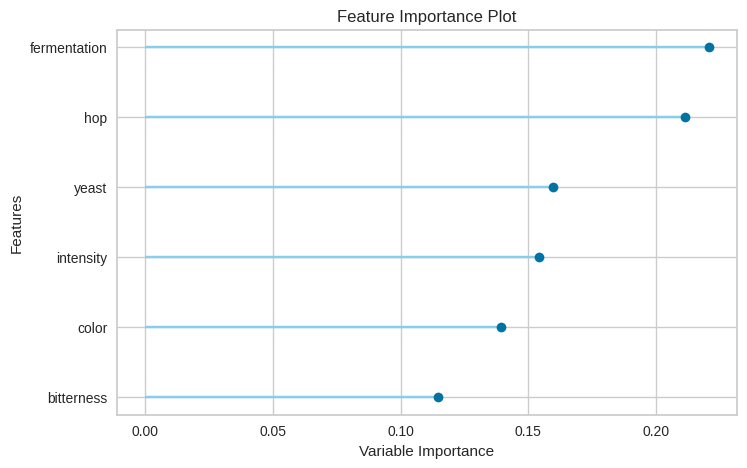

In [15]:
plot_model(dt, plot = 'feature')

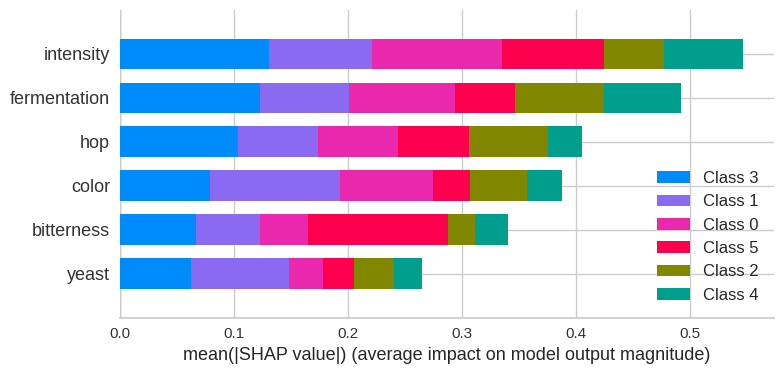

In [16]:
interpret_model(dt)

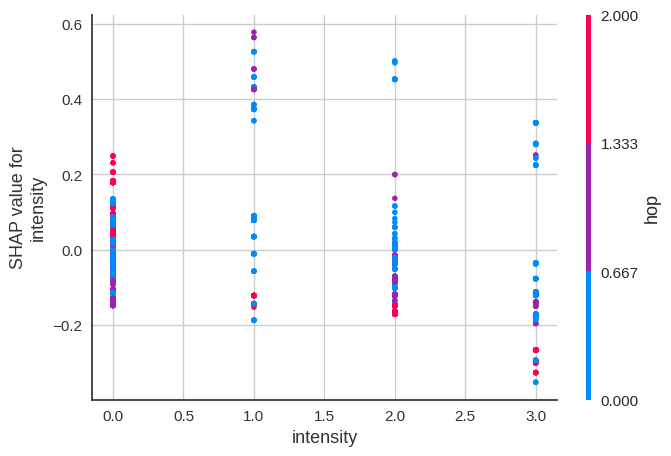

In [17]:
interpret_model(dt, plot = 'correlation')